In [193]:
# this notebook contains a function
# to call ANN-Sur in a way more
# suitable for PE

# you specify a sample rate and segment length

# imports

In [194]:
import matplotlib.pyplot as plt

In [195]:
import numpy as np

In [196]:
import tensorflow as tf

In [197]:
from tensorflow_probability.python.math.interpolation import interp_regular_1d_grid
from tensorflow_probability.python.math import interpolation as tfp_interp

In [198]:
import os

In [199]:
import phenom

In [200]:
import lal

In [201]:
from scrinet.interfaces import lalutils

In [202]:
from scrinet.workflow.pipe_utils import load_model

# functions

In [203]:
def setup_surrogate(user="sk"):
    if user == "sk":
#         rootdir = "/Users/spx8sk/work/data/scrinet/3D_NP"
        rootdir = "/Users/spx8sk/work/data/scrinet/ann-sur-final-model"
    elif user == "rg":
        rootdir = '/Users/Rhys/Documents/PhD/PE/NN_for_PE/3D_NP'
        
    amp_basis = os.path.join(rootdir, "amp_eim_basis.npy")
    amp_model_dir = os.path.join(rootdir, "results_4_320_relu_Adam")

    phase_basis = os.path.join(rootdir, "phase_eim_basis.npy")
    phase_model_dir = os.path.join(rootdir, "results_4_320_softplus_Adamax")

    amp_model, amp_basis = load_model(
        basis_file=amp_basis,
        nn_weights_file=os.path.join(amp_model_dir, "model.h5"),
        X_scalers_file=os.path.join(amp_model_dir, "X_scalers.npy"),
        Y_scalers_file=""
    )

    phase_model, phase_basis = load_model(
        basis_file=phase_basis,
        nn_weights_file=os.path.join(phase_model_dir, "model.h5"),
        X_scalers_file=os.path.join(phase_model_dir, "X_scalers.npy"),
        Y_scalers_file=os.path.join(phase_model_dir, "y_scalers.npy")
    )
    
    amp_basis = tf.convert_to_tensor(amp_basis, dtype = tf.float32)
    phase_basis = tf.convert_to_tensor(phase_basis, dtype = tf.float32)
    
    return amp_model, amp_basis, phase_model, phase_basis

In [204]:
# @tf.function(experimental_compile=True, autograph=True, experimental_relax_shapes=True)
def amp_predict_hack(model, _input):
    """
    Function to re-create model.predict(input) but allows the graph to be built correctly
    (see https://github.com/tensorflow/tensorflow/issues/33997)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to make a prediction
    :return:
    """
    x = _input
    x = x_scale_hack(model, x)
    pred = tf.convert_to_tensor(x)
    # the three should be an argument for ndim of problem
    pred = tf.reshape(pred, shape=(-1, 3))
    net_layers = model.model.layers
    output_shape = net_layers[-1].output_shape[-1]
    for layer in net_layers:
        pred = layer(pred)
    pred = tf.reshape(
        pred, shape=(-1, output_shape,))
    return pred


# @tf.function(experimental_compile=True, autograph=True, experimental_relax_shapes=True)
def phase_predict_hack(model, _input):
    """
    Function to re-create model.predict(input) but allows the graph to be built correctly
    (see https://github.com/tensorflow/tensorflow/issues/33997)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to make a prediction
    :return:
    """
    x = _input
    x = x_scale_hack(model, x)
    pred = tf.convert_to_tensor(x)
    # the three should be an argument for ndim of problem
    pred = tf.reshape(pred, shape=(-1, 3))
    net_layers = model.model.layers
    output_shape = net_layers[-1].output_shape[-1]
    for layer in net_layers:
        pred = layer(pred)
    pred = tf.reshape(
        pred, shape=(-1, output_shape,))
#     pred = y_inv_scale_hack(model, pred)
    pred = y_inv_minmax_scale_hack(model, pred)
    return pred


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def x_scale_hack(model, _input):
    """
    Function to re-create sklearn standard scaler for the input (as a tensorflow function)

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    x = _input
    means = tf.constant([model.X_scalers[i].mean_[0]
                         for i in range(x.shape[0])])
    stds = tf.constant([model.X_scalers[i].scale_[0]
                        for i in range(x.shape[0])])
    means = tf.cast(means, tf.float32)
    stds = tf.cast(stds, tf.float32)

    x_scaled = (tf.reshape(x, shape=(-1, x.shape[0],)) - means) / stds
    x_scaled = tf.cast(x_scaled, tf.float32)
    return x_scaled


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_std_scalers(model, _input):
    """
    Re-casts the sklearn output std scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    std = [model.Y_scalers[i].scale_[0] for i in range(_input.shape[1])]
    std = tf.stack(std, axis=0)
    std = tf.cast(std, tf.float32)
    return std


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_mean_scalers(model, _input):
    """
    Re-casts the sklearn output mean scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    mean = [model.Y_scalers[i].mean_[0] for i in range(_input.shape[1])]
    mean = tf.stack(mean, axis=0)
    mean = tf.cast(mean, tf.float32)
    return mean


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def y_inv_scale_hack(model, _input):
    """
    Re-creates the sklearn inverse standard scaler as a tensorflow function,

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    y_scaled = _input
    y_scaled = tf.reshape(y_scaled, shape=(-1, y_scaled.shape[1]))

    mean = get_model_y_mean_scalers(model, _input)

    std = get_model_y_std_scalers(model, _input)
    y = y_scaled * std + mean
    return y

# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_minmax_scale_scalers(model, _input):
    """
    Re-casts the sklearn output scale scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    scale = [model.Y_scalers[i].scale_[0] for i in range(_input.shape[1])]
    scale = tf.stack(scale, axis=0)
    scale = tf.cast(scale, tf.float32)
    return scale


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def get_model_y_minmax_min_scalers(model, _input):
    """
    Re-casts the sklearn output min scalers for each output basis

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    mins = [model.Y_scalers[i].min_[0] for i in range(_input.shape[1])]
    mins = tf.stack(mins, axis=0)
    mins = tf.cast(mins, tf.float32)
    return mins


# @tf.function(experimental_compile=True, experimental_relax_shapes=True)
def y_inv_minmax_scale_hack(model, _input):
    """
    Re-creates the sklearn inverse standard scaler as a tensorflow function,

    :param model: A trained scrinet Neural Network
    :param _input: The point at which you want to scale
    :return:
    """
    y_scaled = _input
    y_scaled = tf.reshape(y_scaled, shape=(-1, y_scaled.shape[1]))

    mins = get_model_y_minmax_min_scalers(model, _input)

    scale = get_model_y_minmax_scale_scalers(model, _input)
    y = (y_scaled - mins) / scale
    return y


In [205]:
# we need a function to tell us the time before merger for a particular frequency
# we can estimate this using PN
# from https://github.com/gwastro/pycbc/blob/master/pycbc/waveform/spa_tmplt.py
# non-spinning only
# removed the 'porder' and hardcoding max-order
# @tf.function(experimental_relax_shapes=True)
# @tf.function()
def tf_findchirp_chirptime(m1, m2, fLower):
    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.

    c7T = lal.PI * (14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0)

    c6T = lal.GAMMA * 6848.0 / 105.0 - 10052469856691.0 / 23471078400.0 +\
        lal.PI * lal.PI * 128.0 / 3.0 + \
        eta * (3147553127.0 / 3048192.0 - lal.PI * lal.PI * 451.0 / 12.0) -\
        eta * eta * 15211.0 / 1728.0 + eta * eta * eta * 25565.0 / 1296.0 +\
        eta * eta * eta * 25565.0 / 1296.0 + tf.math.log(4.0) * 6848.0 / 105.0
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * lal.PI * eta / 3.0 - 7729.0 * lal.PI / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * lal.PI / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * lal.MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = tf.pow (lal.PI * m * lal.MTSUN_SI * fLower, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.

    # This formula works for any PN order, because
    # higher order coeffs will be set to zero.
    return c0T * (1 + c2T * x2T + c3T * x3T + c4T * x4T + c5T * x5T + (c6T + c6LogT * tf.math.log(xT)) * x6T + c7T * x7T) / x8T

In [206]:
# @tf.function(experimental_compile=True)
# @tf.function()
def tf_chieffective(m1, m2, s1z, s2z):
    """
    https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimInspiralTaylorF2ReducedSpin.c#L46
    /* sanity checks */
    if (m1 <= 0) XLAL_ERROR(XLAL_EDOM);
    if (m2 <= 0) XLAL_ERROR(XLAL_EDOM);
    if (fabs(s1z) > 1) XLAL_ERROR(XLAL_EDOM);
    if (fabs(s2z) > 1) XLAL_ERROR(XLAL_EDOM);
    """
    m = m1 + m2
    eta = m1 * m2 / (m * m)
    delta = (m1 - m2) / m
    chi_s = (s1z + s2z) / 2.
    chi_a = (s1z - s2z) / 2.

    return chi_s * (1. - 76. * eta / 113.) + delta * chi_a;

In [207]:
# @tf.function(experimental_compile=True)
# @tf.function()
def tf_XLALSimInspiralTaylorF2ReducedSpinChirpTime(
    m1,   #/**< mass of companion 1 (Msun) */
    m2,   #/**< mass of companion 2 (Msun) */
    chi,     #/**< dimensionless aligned-spin param */
    fStart  #/**< start GW frequency (Hz) */
    ):
    """
    https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimInspiralTaylorF2ReducedSpin.c#L307
#     if (fStart <= 0) XLAL_ERROR(XLAL_EDOM);
#     if (m1_SI <= 0) XLAL_ERROR(XLAL_EDOM);
#     if (m2_SI <= 0) XLAL_ERROR(XLAL_EDOM);
#     if (fabs(chi) > 1) XLAL_ERROR(XLAL_EDOM);


    returns tau (chirp time in seconds)
    
    """
    m = m1+m2
    eta = m1*m2/(m*m)
    eta2 = eta*eta
    chi2 = chi*chi
    sigma0 = (-12769*(-81. + 4.*eta))/(16.*(-113. + 76.*eta)*(-113. + 76.*eta))
    gamma0 = (565*(-146597. + 135856.*eta + 17136.*eta2))/(2268.*(-113. + 76.*eta))

#     https://git.ligo.org/lscsoft/lalsuite/-/blob/master/lalsimulation/lib/LALSimInspiralTaylorF2ReducedSpin.c#L31
# # this is PI**2
    Pi_p2 = 9.8696044010893586188344909998761511
    
    v = tf.pow(lal.PI * m * lal.MTSUN_SI * fStart, 1./3.)
    vk = v  #/* v^k */
#     REAL8 tk[8];  /* chirp time coefficients up to 3.5 PN */
#     /* chirp time coefficients up to 3.5PN  */
    tk0 = (5.*m*lal.MTSUN_SI)/(256.*tf.pow(v,8)*eta)
    tk1 = 0.
    tk2 = 2.9484126984126986 + (11*eta)/3.
    tk3 = (-32*lal.PI)/5. + (226.*chi)/15.
    tk4 = 6.020630590199042 - 2*sigma0*chi2 + (5429*eta)/504. + (617*eta2)/72.
    tk5 = (3*gamma0*chi)/5. - (7729*lal.PI)/252. + (13*lal.PI*eta)/3.
    tk6 = -428.291776175525 + (128*Pi_p2)/3. + (6848*lal.GAMMA)/105. + (3147553127*eta)/3.048192e6 - (451*Pi_p2*eta)/12. - (15211*eta2)/1728. + (25565*eta2*eta)/1296. + (6848*tf.math.log(4*v))/105.
    tk7 = (-15419335*lal.PI)/127008. - (75703*lal.PI*eta)/756. + (14809*lal.PI*eta2)/378.

    vk2 = vk*v
    vk3 = vk2*v
    vk4 = vk3*v
    vk5 = vk4*v
    vk6 = vk5*v
    vk7 = vk6*v
    
    tau = tk0 * (1 + tk2*vk2 + tk3*vk3 + tk4*vk4 + tk5*vk5 + tk6*vk6 + tk7*vk7)

    return tau

In [208]:
# @tf.function(experimental_compile=True)
# @tf.function()
def tf_get_surrogate_index_and_value_at_f_lower(m1,m2,s1z, s2z, flower):
    """
    returns the first index above the input flower
    and the value at that index
    """
#     time_at_flower_sec = -tf_findchirp_chirptime(m1,m2,flower)
    chi = tf_chieffective(m1,m2,s1z,s2z)
    time_at_flower_sec = -tf_XLALSimInspiralTaylorF2ReducedSpinChirpTime(m1,m2,chi, flower)
    time_at_flower_M = tf.cast(phenom.StoM(time_at_flower_sec, m1+m2), tf.float64)
    
    # hardcoded to the final ann-sur model
    tstart_M = tf.cast(-20000., tf.float64)
    tend_M = 100.
    tnum = 40000
    
    # comment this out to support XLA compilation
#     tf.debugging.assert_greater_equal(
#         time_at_flower_M,
#         tstart_M,
#         message=f"error: flower too low. flower = {flower}. time_at_flower_M = {time_at_flower_M}"
#     )
    
    surrogate_times = tf.linspace(tstart_M, tend_M, tnum)
    dt_M = surrogate_times[1] - surrogate_times[0]
    
    target_indexs = tf.cast(tf.floor((20000. + time_at_flower_M) / dt_M), tf.int32)
    
    vals = tf.gather(surrogate_times, target_indexs)
    
    return target_indexs, vals

In [209]:
# @tf.function
def y22_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = tf.math.sqrt( 5.0 / ( 64.0 * lal.PI ) ) * ( 1.0 + tf.math.cos( theta ))*( 1.0 + tf.math.cos( theta ))
    
    m = tf.cast(2., tf.complex64)
    return tf.math.exp(1.j * m * tf.cast(phi, tf.complex64)) * tf.cast(fac, tf.complex64)

# @tf.function
def y2m2_func(theta, phi):
    """
    https://lscsoft.docs.ligo.org/lalsuite/lal/_spherical_harmonics_8c_source.html#l00042
    """
    fac = tf.math.sqrt( 5.0 / ( 64.0 * lal.PI ) ) * ( 1.0 - tf.math.cos( theta ))*( 1.0 - tf.math.cos( theta ))
    
    m = tf.cast(-2., tf.complex64)
    return tf.math.exp(1.j * m * tf.cast(phi, tf.complex64)) * tf.cast(fac, tf.complex64)

In [210]:
# N = 2
# M = 10

# start_end = [[2, 8], [4, 6]]

# @tf.function(experimental_compile=True)
# @tf.function()
def make_rect_window_tensor(M, start_end):
    B = []
    for se in start_end:
        B.append( tf.ones(se[1]-se[0]) )
    C = [tf.pad(B[i], [[start_end[i][0], M-start_end[i][1]]]) for i in range(len(start_end))]
    return tf.convert_to_tensor(C)

In [211]:
def apply_roll(tensor_in, shifts):
    """
    tensor_in: input tensor to roll - shape = N,M (N waveforms, M samples in time)
    shifts: tensor - shape = N,
        number of indicies to shift each row by
        
    returns: the rolled tensor
    
    """
    rolled = [tf.roll(tensor_in[i], shifts[i], axis=0) for i in range(tensor_in.shape[0])]
    return tf.convert_to_tensor(rolled)

In [396]:
# based on generate_surrogate in sample_helpers.py
@tf.function(experimental_compile=True)
# @tf.function()
def generate_surrogate_hp_hc(
    x,
    f_lower,
    seglen,
    sample_rate,
    theta,
    phi,
    mtot, 
    dist,
    phase_shift,
    amp_model,
    amp_basis,
    phase_model,
    phase_basis
):
    """
    generate hplus and hcross. the shape is NxM
        N = number of waveforms
        M = seglen/samples_rate
    times start at 0s and extend for seglen seconds
    the returned data have the sample sample-rate and duration.
    they also start at the correct start frequency
    so waveforms with different parameters will have different lengths

    f_lower, : shape = scalar
    seglen, : shape = scalar in seconds - duration of output times
    sample_rate, : shape = scalar in seconds

    :param theta: sphharm polar : shape = N,1
    :param phi: sphharm azimuth : shape = N,1
    :param mtot: total mass in Msun : shape = N,1
    :param dist: distance in metre : shape = N,1

    :param x: The location in parameter space - currently (q, chi1, chi2) : shape = N,3
    :param amp_model: The pre-loaded amplitude nn generator
    :param amp_basis: The pre-loaded amplitude basis
    :param phase_model: The pre-loaded phase nn generator
    :param phase_basis: The pre-loaded phase basis
    :param phase_shift: phase shift (default: 0.) : shape = N,1
    
    :return:
    
    surr_times_sec: times in seconds: shape = (1,)
    hp_rolled: plus pol : shape = (N, M)
    hc_rolled: cross pol : shape = (N, M)
    -start_times: approximate time of merger : shape = (N, 1)


    """
    N = x.shape[0]
    sample_rate_M = phenom.StoM(sample_rate, mtot)
    
    q = tf.transpose(tf.expand_dims(x[:, 0], 0))
    s1z = tf.transpose(tf.expand_dims(x[:, 1], 0))
    s2z = tf.transpose(tf.expand_dims(x[:, 2], 0))
#     print(q)
    m1, m2 = phenom.m1_m2_M_q(mtot, q)

    x = tf.transpose(tf.stack([tf.math.log(x[:, 0]), x[:, 1], x[:, 2]], axis=0))
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, shape=(-1, x.shape[0]))
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    amp_alpha = amp_predict_hack(amp_model, x)
    amp = tf.tensordot(amp_alpha, amp_basis, axes=1)
    phase_alpha = phase_predict_hack(phase_model, x)
    phase = tf.tensordot(phase_alpha, phase_basis, axes=1)
    phase_shift = tf.cast(phase_shift, dtype=phase.dtype)
    phase = phase + phase_shift
    
#     amp_pre_fac = tf.expand_dims(lalutils.td_amp_scale(mtot, dist) * phenom.eta_from_q(q), 1)

#     print("1")
#     print(lalutils.td_amp_scale(mtot, dist))
#     print("2")
#     print(phenom.eta_from_q(q))
    amp_pre_fac = lalutils.td_amp_scale(mtot, dist) * phenom.eta_from_q(q)
    
#     print(amp.shape)
#     print(amp_pre_fac)
    
    amp = amp * amp_pre_fac

    idx, val = tf_get_surrogate_index_and_value_at_f_lower(m1, m2, s1z, s2z, f_lower)
    
#     print(f"idx = {idx}")
#     print(f"val = {val}")
    
    original_idx = idx
    original_val = val # i think this can be use to estimate the epoch
    
#     print(val)
#     print(idx, val)
#     print(f"argmin: {tf.argmin(idx)}")
    val_idx = tf.argmin(idx)[0]
    idx = idx[tf.argmin(idx)[0],0]
#     print(f"idx: {idx}")
#     print(f"val: {val}")
#     print(f"val_idx: {val_idx}")
    val = tf.cast(val[val_idx, 0], dtype=tf.float32)
    
#     print(idx)
#     print(val)
    
    # we can't interpolate onto different length grids
    # because tensorflow tensors needs to have constant length rows.
    # or can use ragged tensors?
    #
    # so lets just take the longests waveform, lowests 'val'
    
    # these numbers are specific to the time axis of the surrogate
    x_ref_min = -20000.
# #     x_ref_min = val
    x_ref_max = 100.
#     times_M = tf.range(val, x_ref_max, sample_rate)
    
#     iy = interp_regular_1d_grid(
#         x=times_M, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=tf.stack((amp[:,idx:], phase[:,idx:]))
#     )

#     print(tf.cast(amp[:,idx:].shape[1], tf.float64))
#     5664

    tfdt = tf.cast(sample_rate_M, tf.float64)
    
        
#     times_M = (tf.range(tf.cast(5664, tf.float64))) * tfdt - tf.abs(tf.cast(val, tf.float64))
    # to support XLA compilation need to get 'amp[:,idx:].shape[1]' from somewhere else?
    # i suppose the times could be an input to this function? 
    # the same goes for the tf_get_surrogate_index_and_value_at_f_lower function.
    # to get XLA to work with this function these need to be computed before hand.
#     times_M = (tf.range(tf.cast(amp[:,idx:].shape[1], tf.float64))) * tfdt - tf.abs(tf.cast(val, tf.float64))

    num_T = tf.cast(tf.cast(seglen / sample_rate, tf.int32), tf.float64)
#     print(num_T)
    times_M = tf.range(num_T) * tfdt - tf.abs(tf.cast(val, tf.float64))
    times_M_f32 = tf.cast(times_M, tf.float32)
#     print(f"val = {val}")
#     print(times_M)

    x_ref_min = val * tf.ones(N)
    x_ref_max = x_ref_max * tf.ones(N)

    iy = tfp_interp.batch_interp_regular_1d_grid(
        x=times_M_f32,
        x_ref_min=x_ref_min,
        x_ref_max=x_ref_max,
        y_ref=tf.stack((amp[:,idx:], phase[:,idx:])),
#         fill_value=0 # comment this line out to work with tf.function.... not sure why....
    )

#     x_ref_min = -20000
#     x_ref_max = 100
#     times_M = tf.range(val, x_ref_max, sample_rate)
#     iy = interp_regular_1d_grid(
#         x=times_M, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=tf.stack((amp, phase)))


    new_amp = iy[0]
    new_phase = iy[1]

    phase = tf.cast(new_phase, tf.complex64)
    amp = tf.cast(new_amp, tf.complex64)
    
    theta = tf.cast(theta, tf.float32)
    phi = tf.cast(phi, tf.float32)
    
    h22 = amp * tf.math.exp(-1.j * phase)
    
#     hplus = np.real(0.5 * (h22 + tf.math.conj(h22)))
#     hcross = np.real(1.j * 0.5 * (h22 - tf.math.conj(h22)))

    y22 = y22_func(theta, phi)
    y2m2 = y2m2_func(theta, phi)

    h = h22*y22 + tf.math.conj(h22)*y2m2
    
    hplus = tf.math.real(h)
    hcross = tf.math.imag(h)
    
#     return tf.math.real(hplus), tf.math.real(hcross)

    surr_times_sec = phenom.MtoS(
        times_M,
        tf.cast(mtot, tf.float64)
    )
    
    
    
    # negative becuase these times start at negative values
    epochs = -surr_times_sec[:,0][:,tf.newaxis]

    surr_times_sec = surr_times_sec + epochs

    
    # finally here lets pad to the desired seglen
    # right now all waveforms have the same shape and sample-rate
    # so padding to desired seglen should be easy
    # tf.pad?
    
    start_times = phenom.MtoS(original_val, tf.cast(mtot, tf.float64))
    
    index_start_freq = tf.cast((epochs+start_times) / sample_rate, tf.int32)

    extra_time = phenom.MtoS(150, tf.cast(mtot, tf.float64))
    
    index_peak_amp = tf.cast((epochs+extra_time)/sample_rate, tf.int32)

    num_T_i32 = tf.cast(num_T, tf.int32)
    ab = tf.transpose((index_start_freq, index_peak_amp))
    
    window = make_rect_window_tensor(num_T_i32, [ ab[0,i] for i in range(N)])
    
#     hp_rolled = apply_roll(hplus*window, -tf.reshape(index_start_freq, (N,)))
#     hc_rolled = apply_roll(hcross*window, -tf.reshape(index_start_freq, (N,)))
    
    index_peak_amp = tf.cast((epochs)/sample_rate, tf.int32)

    hp_rolled = apply_roll(hplus*window, -tf.reshape(index_peak_amp, (N,)))
    hc_rolled = apply_roll(hcross*window, -tf.reshape(index_peak_amp, (N,)))
    
    return surr_times_sec[0], hp_rolled, hc_rolled, -start_times

# call

In [397]:
amp_model, amp_basis, phase_model, phase_basis = setup_surrogate(user="sk")

In [398]:
# x = tf.constant([
#     [1,0,0],
#     [2,0,0]
# ], dtype=np.float32)
# theta = tf.constant([[np.pi/3], [np.pi/2]])
# phi = tf.constant([[0.], [np.pi/2]])
# mtot = tf.constant([[60.], [80.]])
# dist = tf.constant([[1.],[2.]])
# phase_shift = tf.constant([[1.],[2.]])


x = tf.constant([
    [1,-1,-1],
    [1,0,0],
    [1,1,1]
], dtype=np.float32)
theta = tf.constant([[np.pi/3], [np.pi/2], [np.pi/3]])
phi = tf.constant([[0.], [np.pi/2], [np.pi/8]])
mtot = tf.constant([[60.], [60.], [120.]])
dist = tf.constant([[2.3],[2.3],[2.3]])
phase_shift = tf.constant([[1.],[2.],[-1.23]])


f_lower = 20.


seglen = 4.
# seglen = 8.

# this is actually dt...
sample_rate = 1/2048./2


In [399]:
1./sample_rate

4096.0

In [414]:
# # f_lower and sample-rate should always be constant and so can just be scalars (0-D Tensor)
surr_times_sec, hplus, hcross, unrolled_peak_time = generate_surrogate_hp_hc(
    x=x,
    f_lower=f_lower,
    seglen=seglen,
    sample_rate=sample_rate,
    theta=theta,
    phi=phi,
    mtot=mtot,
    dist=dist,
    phase_shift=phase_shift,
    amp_model=amp_model,
    amp_basis=amp_basis,
    phase_model=phase_model,
    phase_basis=phase_basis
)

In [401]:
surr_times_sec

<tf.Tensor: shape=(16384,), dtype=float64, numpy=
array([0.00000000e+00, 2.44140638e-04, 4.88281275e-04, ...,
       3.99926779e+00, 3.99951193e+00, 3.99975607e+00])>

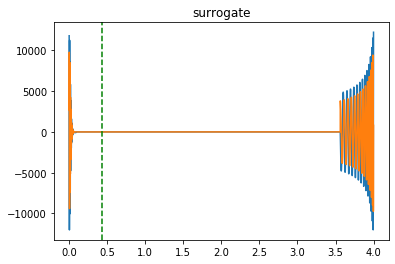

In [416]:
for i in range(hplus.shape[0]):
    plt.figure()
    plt.plot(surr_times_sec, hplus[i])
    plt.plot(surr_times_sec, hcross[i])
    plt.title("surrogate")
    
    plt.axvline(unrolled_peak_time[i], c='g', ls='--')
#     plt.xlim(unrolled_peak_time[i]-0.1 , unrolled_peak_time[i]+0.1)
#     plt.xlim(0, seglen)
#     plt.xlim(0, 0.2)
    plt.show()
    plt.close()

In [403]:
from scrinet.analysis import timeseries_batch

In [404]:
surr_times_sec[1]-surr_times_sec[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.000244140637727888>

In [405]:
sample_rate

0.000244140625

In [406]:
ts = timeseries_batch.TimeSeries(hplus, delta_t=sample_rate)

In [407]:
ts.data

<tf.Tensor: shape=(3, 16384), dtype=float32, numpy=
array([[  749.9848,  -776.7018, -2279.959 , ...,  4472.682 ,  3447.774 ,
         2185.6348],
       [ -810.0346,   646.6482,  2068.4746, ..., -4098.9927, -3277.6978,
        -2155.6875],
       [11787.183 , 10888.754 ,  9547.394 , ..., 11683.524 , 12177.405 ,
        12217.287 ]], dtype=float32)>

In [408]:
ts.sample_times

<tf.Tensor: shape=(3, 16384), dtype=float32, numpy=
array([[0.0000000e+00, 2.4414062e-04, 4.8828125e-04, ..., 3.9992676e+00,
        3.9995117e+00, 3.9997559e+00],
       [0.0000000e+00, 2.4414062e-04, 4.8828125e-04, ..., 3.9992676e+00,
        3.9995117e+00, 3.9997559e+00],
       [0.0000000e+00, 2.4414062e-04, 4.8828125e-04, ..., 3.9992676e+00,
        3.9995117e+00, 3.9997559e+00]], dtype=float32)>

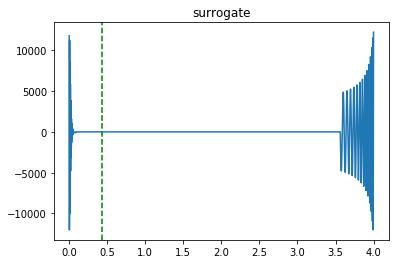

In [417]:
for i in range(ts.data.shape[0]):
    plt.figure()
    plt.plot(ts.sample_times[i], ts.data[i])
    plt.title("surrogate")
    
    plt.axvline(unrolled_peak_time[i], c='g', ls='--')
#     plt.xlim(start_times[i]-0.1 , start_times[i]+0.1)
#     plt.xlim(0, seglen)
#     plt.xlim(0, 0.2)
    plt.show()
    plt.close()

In [418]:
dt = tf.constant([[1.],[2.4],[1.9]], dtype=tf.float64)
fs = ts.to_frequencyseries()

freqs = fs.get_sample_frequencies()
freqs = tf.cast(freqs, tf.complex64)

fac = tf.math.exp(-1j * 2 * np.pi * tf.cast(dt, tf.complex64) * freqs)

# print(fac)
# print(detector_h_ts.data)
fs.data = fs.data * fac

shift_ts = fs.to_timeseries()

In [419]:
dt

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1. ],
       [2.4],
       [1.9]])>

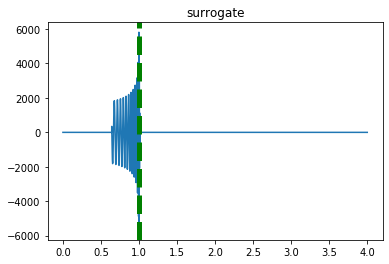

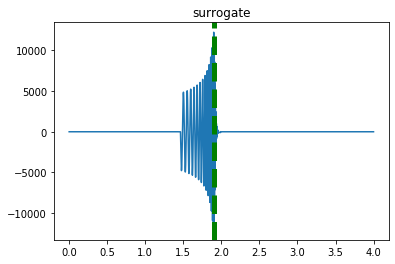

In [420]:
for i in range(ts.data.shape[0]):
    plt.figure()
#     plt.plot(ts.sample_times[i], ts.data[i])
    plt.plot(shift_ts.sample_times[i], tf.math.real(shift_ts.data[i]))
    plt.title("surrogate")
    
    plt.axvline(dt[i], c='g', ls='--', lw=5)
#     plt.axvline(start_times[i] + dt[i], c='g', ls='--', lw=5)
#     plt.xlim(start_times[i]-0.1 , start_times[i]+0.1)
#     plt.xlim(0, seglen)
#     plt.xlim(0, 0.2)
    plt.show()
    plt.close()